# **DMML Assignment 1**

# **Task 2: Supermarket Sales**

submission by Utpalraj Kemprai(MDS202352)

In [17]:
# importing libraries for use
# python version 3.8.5
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,classification_report

### **Storing and reading first few rows of the SuperMarket Data**

In [18]:
data = pd.read_csv("supermarket-sales-data.csv")
data.head()

,InvoiceID,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
0,750-67-8428,A,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,UPI,9.1
1,226-31-3081,C,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,9.6
2,631-41-3108,A,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,7.4
3,123-19-1176,A,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,UPI,8.4
4,373-73-7910,A,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,UPI,5.3


In [19]:
data.dtypes

InvoiceID        object
Branch           object
CustomerType     object
Gender           object
ProductType      object
UnitPrice       float64
Quantity          int64
Tax             float64
Total           float64
PaymentType      object
Rating          float64
dtype: object

### Checking for missing values

In [20]:
data.isna().sum()

InvoiceID       0
Branch          0
CustomerType    0
Gender          0
ProductType     0
UnitPrice       0
Quantity        0
Tax             0
Total           0
PaymentType     0
Rating          0
dtype: int64

### Correlation Heat Map for Numerical Data

<AxesSubplot:>

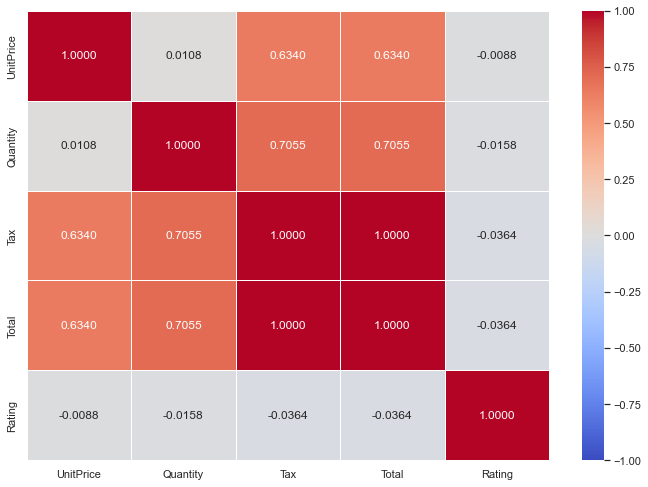

In [21]:
num_data = data.iloc[:,1:].select_dtypes(include = ["float64","int64"]) # InvoiceID is dropped as it is redundant for prediction
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(num_data.corr(),annot=True,cmap="coolwarm",linewidths=0.5,vmin=-1,vmax=1,fmt=".4f")

##### We see from the above heatmap that Tax and Total are perfectly correlated (correlation coefficient = 1). So in building a classfier we can drop one of Tax or Total with no loss of information.

### Encoding the non-numeric columns in the data

In [22]:
obj_columns = data.iloc[:,1:].select_dtypes(include=['object']).columns
obj_columns # columns of data with type object

Index(['Branch', 'CustomerType', 'Gender', 'ProductType', 'PaymentType'], dtype='object')

In [23]:
from sklearn.preprocessing import LabelEncoder
for col in obj_columns:
    enc = LabelEncoder()
    enc.fit(data[col].unique())
    data[col] = enc.transform(data[col])

In [24]:
# classes in the encoded columns 
data.head()

,InvoiceID,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
0,750-67-8428,0,0,0,3,74.69,7,26.1415,548.9715,2,9.1
1,226-31-3081,2,1,0,0,15.28,5,3.8200,80.2200,0,9.6
2,631-41-3108,0,1,1,4,46.33,7,16.2155,340.5255,1,7.4
3,123-19-1176,0,0,1,3,58.22,8,23.2880,489.0480,2,8.4
4,373-73-7910,0,1,1,5,86.31,7,30.2085,634.3785,2,5.3


In [25]:
data.dtypes

InvoiceID        object
Branch            int32
CustomerType      int32
Gender            int32
ProductType       int32
UnitPrice       float64
Quantity          int64
Tax             float64
Total           float64
PaymentType       int32
Rating          float64
dtype: object

#### In the data, gender columns male has been encoded as 1 and female as 0

In [26]:
data.describe()

,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.988000,0.499000,0.499000,2.452000,55.672130,5.510000,15.379369,322.966749,1.001000,6.97270
std,0.817633,0.500249,0.500249,1.715412,26.494628,2.923431,11.708825,245.885335,0.830475,1.71858
min,0.000000,0.000000,0.000000,0.000000,10.080000,1.000000,0.508500,10.678500,0.000000,4.00000
25%,0.000000,0.000000,0.000000,1.000000,32.875000,3.000000,5.924875,124.422375,0.000000,5.50000
50%,1.000000,0.000000,0.000000,2.000000,55.230000,5.000000,12.088000,253.848000,1.000000,7.00000
75%,2.000000,1.000000,1.000000,4.000000,77.935000,8.000000,22.445250,471.350250,2.000000,8.50000
max,2.000000,1.000000,1.000000,5.000000,99.960000,10.000000,49.650000,1042.650000,2.000000,10.00000


### Percentage of Male in given data

In [27]:
sum(data['Gender']==1)*100/len(data['Gender'])

49.9

In [28]:
data[data['Gender'] == 1].describe() #male

,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
count,499.000000,499.000000,499.0,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.941884,0.519038,1.0,2.460922,56.081944,5.292585,14.799487,310.789226,1.038076,6.980962
std,0.810715,0.500139,0.0,1.696907,25.794145,2.947084,11.524844,242.021730,0.838670,1.682146
min,0.000000,0.000000,1.0,0.000000,10.080000,1.000000,0.508500,10.678500,0.000000,4.000000
25%,0.000000,0.000000,1.0,1.000000,33.825000,3.000000,5.616500,117.946500,0.000000,5.600000
50%,1.000000,1.000000,1.0,2.000000,56.500000,5.000000,11.630000,244.230000,1.000000,6.900000
75%,2.000000,1.000000,1.0,4.000000,76.670000,8.000000,21.754000,456.834000,2.000000,8.450000
max,2.000000,1.000000,1.0,5.000000,99.960000,10.000000,49.490000,1039.290000,2.000000,10.000000


In [29]:
data[data['Gender'] == 0].describe() #female

,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
count,501.000000,501.000000,501.0,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,1.033932,0.479042,0.0,2.443114,55.263952,5.726547,15.956936,335.095659,0.964072,6.964471
std,0.822707,0.500060,0.0,1.735298,27.194037,2.886360,11.872591,249.324401,0.821405,1.755761
min,0.000000,0.000000,0.0,0.000000,10.160000,1.000000,0.604500,12.694500,0.000000,4.000000
25%,0.000000,0.000000,0.0,1.000000,30.620000,3.000000,6.322000,132.762000,0.000000,5.400000
50%,1.000000,0.000000,0.0,2.000000,54.070000,6.000000,12.980000,272.580000,1.000000,7.100000
75%,2.000000,1.000000,0.0,4.000000,78.880000,8.000000,23.164000,486.444000,2.000000,8.500000
max,2.000000,1.000000,0.0,5.000000,99.730000,10.000000,49.650000,1042.650000,2.000000,10.000000


### **Splitting the data into training and testing data**

In [30]:
from sklearn.model_selection import train_test_split
pred_cols = []
for col in data.columns:
    if col not in ['Gender','InvoiceID','Tax']: # Tax dropped as it has perfect correlation with Total
        pred_cols.append(col)
Xg = data[pred_cols] # features to predict from
yg = data['Gender'] # label to predict
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg,yg,test_size=0.20,random_state=42) # splits 20% for test and 80% for training

## **1. Building a classifier to predict Gender**

### **1.a. Using a Decision Tree Classifier**

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [32]:
parameters_dtc = {}
parameters_dtc['criterion'] = ['gini']
parameters_dtc['max_depth'] = [3,5,7,9,11,None]
parameters_dtc['max_features'] = ['log2','sqrt',None]
parameters_dtc['random_state'] = [0]

#### Hyperparametric Tuning

In [33]:
from sklearn.model_selection import GridSearchCV
dtc_gender = GridSearchCV(dtc,param_grid=parameters_dtc,cv=3,n_jobs=-1,verbose=3,scoring='accuracy')

#### Fitting the data

In [34]:
dtc_gender.fit(Xg_train,yg_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [3, 5, 7, 9, 11, None],
                         'max_features': ['log2', 'sqrt', None],
                         'random_state': [0]},
             scoring='accuracy', verbose=3)

#### Visualizing the Tree

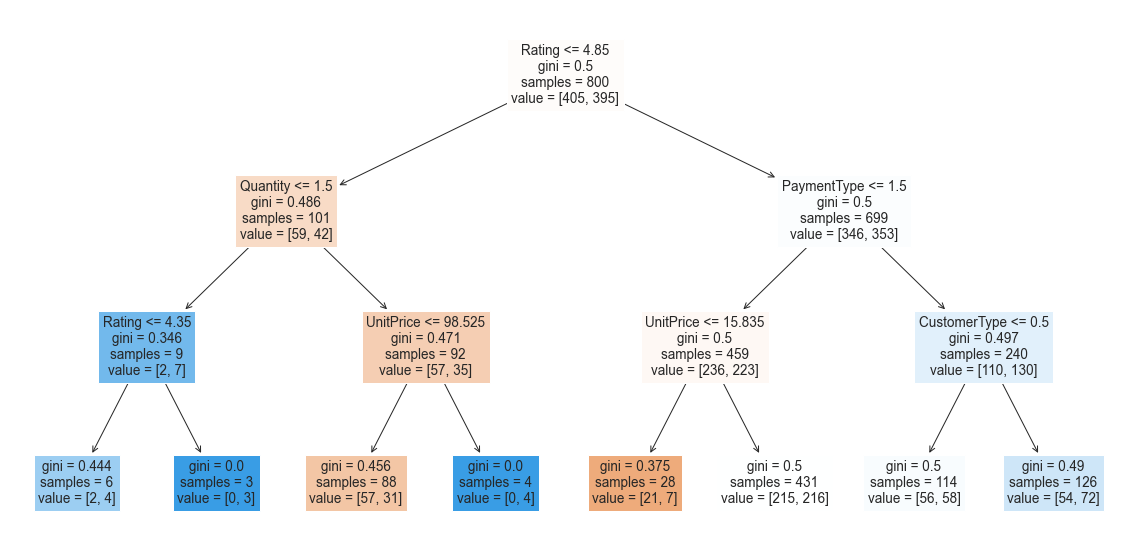

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
_ = plot_tree(dtc_gender.best_estimator_,feature_names=list(Xg.columns),filled=True)


#### The best parameters found and Accuracy on the training data

In [36]:
dtc_gender.best_params_ # best parameters

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'random_state': 0}

In [37]:
dtc_gender.best_score_ # best score

0.5337454122196877

#### Accurcy on the Test Data

In [38]:
dtc_gender.score(Xg_test,yg_test)

0.535

#### Confusion Matrix

In [39]:
confusion_matrix(y_true=yg_test,y_pred=dtc_gender.predict(Xg_test))

array([[20, 76],
       [17, 87]], dtype=int64)

#### Accuracy, F score, Precision and Recall

In [40]:
lab = ['Accuracy','F Score','Precision','Recall']
score = [dtc_gender.score(Xg_test,yg_test),f1_score(yg_test,dtc_gender.predict(Xg_test)),
         precision_score(yg_test,dtc_gender.predict(Xg_test)),recall_score(yg_test,dtc_gender.predict(Xg_test))]
dtctest = pd.DataFrame((zip(lab,score)),columns=["Metric","score"])
dtctest

,Metric,score
0,Accuracy,0.535000
1,F Score,0.651685
2,Precision,0.533742
3,Recall,0.836538


### **1.b. Using a Random Forest Classifier**

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [42]:
parameters_rfc = {}
parameters_rfc['n_estimators'] = [50,75,100,125,150,175,200,225]
parameters_rfc['criterion'] = ['gini']
parameters_rfc['max_features'] = ["log2","sqrt",None]
parameters_rfc['max_depth'] = [3,5,7,9,11,None]
parameters_rfc['random_state'] = [0]

#### Fitting the data with Hyperparametric Tuning

In [43]:
rfc_gender = GridSearchCV(rfc,param_grid=parameters_rfc,n_jobs=-1,cv=3,scoring='accuracy',verbose=3)
rfc_gender.fit(Xg_train,yg_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [3, 5, 7, 9, 11, None],
                         'max_features': ['log2', 'sqrt', None],
                         'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225],
                         'random_state': [0]},
             scoring='accuracy', verbose=3)

#### Best parameters and score on the training data 

In [44]:
rfc_gender.best_score_

0.5475157932283893

In [45]:
rfc_gender.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'log2',
 'n_estimators': 100,
 'random_state': 0}

#### Accuracy on the test data

In [46]:
rfc_gender.score(Xg_test,yg_test)

0.505

#### Confusion Matrix

In [47]:
confusion_matrix(yg_test,rfc_gender.predict(Xg_test))

array([[62, 34],
       [65, 39]], dtype=int64)

#### F score, Accuracy, Precision and Recall

In [48]:
lab = ['Accuracy','F Score','Precision','Recall']
score = [rfc_gender.score(Xg_test,yg_test),f1_score(yg_test,rfc_gender.predict(Xg_test)),
         precision_score(yg_test,rfc_gender.predict(Xg_test)),recall_score(yg_test,rfc_gender.predict(Xg_test))]
rfctest = pd.DataFrame((zip(lab,score)),columns=["Metric","score"])
rfctest

,Metric,score
0,Accuracy,0.505000
1,F Score,0.440678
2,Precision,0.534247
3,Recall,0.375000


### Comparing the results

Decision Tree

In [49]:
print("Decision Tree")
print(classification_report(yg_test,dtc_gender.predict(Xg_test),target_names=['Female','Male']))

Decision Tree
              precision    recall  f1-score   support

      Female       0.54      0.21      0.30        96
        Male       0.53      0.84      0.65       104

    accuracy                           0.54       200
   macro avg       0.54      0.52      0.48       200
weighted avg       0.54      0.54      0.48       200



Random Forest

In [50]:
print("Random Forest")
print(classification_report(yg_test,rfc_gender.predict(Xg_test),target_names=['Female','Male']))

Random Forest
              precision    recall  f1-score   support

      Female       0.49      0.65      0.56        96
        Male       0.53      0.38      0.44       104

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



## **2. Building a model to predict Rating**

#### Distribution of Rating

<AxesSubplot:ylabel='Proportion'>

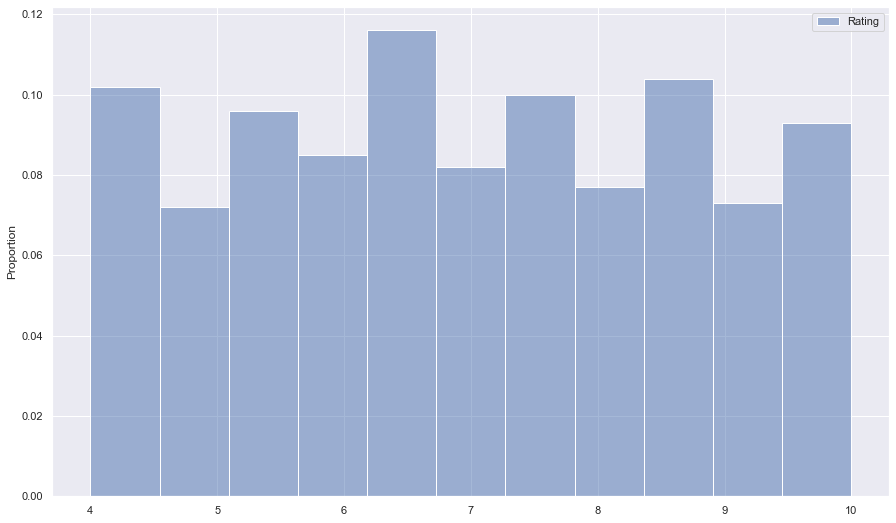

In [128]:
sns.set_theme(rc={'figure.figsize':(15,9)})
sns.histplot(data[['Rating']],stat='proportion')

In [137]:
data[['Rating']].describe()

,Rating
count,1000.00000
mean,6.97270
std,1.71858
min,4.00000
25%,5.50000
50%,7.00000
75%,8.50000
max,10.00000


Setting up the data for predicting Ratings

In [52]:
pred_cols = []
for col in data.columns:
    if col not in ['Rating','InvoiceID','Tax']: # Tax dropped as it has perfect correlation with Total
        pred_cols.append(col)
Xr = data[pred_cols] # features to predict from
yr = data['Rating'] # label to predict

In [53]:
yr.describe()

count    1000.00000
mean        6.97270
std         1.71858
min         4.00000
25%         5.50000
50%         7.00000
75%         8.50000
max        10.00000
Name: Rating, dtype: float64

### Splitting data for training and testing

In [54]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr,yr,test_size=0.20,random_state=42) # splits 20% for test and 80% for training

In [55]:
pred_cols

['Branch',
 'CustomerType',
 'Gender',
 'ProductType',
 'UnitPrice',
 'Quantity',
 'Total',
 'PaymentType']

### **2.1. Using Linear Regression**

In [56]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

#### 2.1.1 Fitting a linear model (degree 1) with all the given features without regularisation

In [57]:
lm.fit(Xr_train,yr_train)

LinearRegression()

##### intercept and coefficients

In [58]:
lm.intercept_,lm.coef_

(6.848387432880459,
 array([-0.04915442,  0.02877777, -0.05699439, -0.03147292,  0.00553778,
         0.06084951, -0.00120981,  0.03030722]))

RMSE as a metric for score

In [93]:
from sklearn.metrics import mean_squared_error

##### RMSE on the Training data

In [94]:
mean_squared_error(yr_train,lm.predict(Xr_train),squared=False) # RMSE

1.703157097611252

##### MAE on the Test Data

In [95]:
mean_squared_error(yr_test,lm.predict(Xr_test),squared=False)

1.765516028673867

#### 2.1.2 Fitting a linear model (degree 1 ) with Lasso


In [96]:
from sklearn.linear_model import Lasso
lm2 = Lasso()
lm2.fit(Xr_train,yr_train)

Lasso()

In [97]:
lm2.intercept_,lm2.coef_

(7.094073149623523,
 array([-0.        ,  0.        , -0.        , -0.        ,  0.        ,
         0.        , -0.00031543,  0.        ]))

In [98]:
mean_squared_error(yr_train,lm2.predict(Xr_train),squared=False)

1.706634422773297

In [99]:
mean_squared_error(yr_test,lm2.predict(Xr_test),squared=False)

1.7566566102254262

#### 2.1.3 Fitting a linear model (degree 1 ) with Ridge

In [100]:
from sklearn.linear_model import Ridge
lm3 = Ridge(alpha=50)
lm3.fit(Xr_train,yr_train)

Ridge(alpha=50)

In [101]:
lm3.intercept_,lm3.coef_

(6.85443870309758,
 array([-0.04456852,  0.02300592, -0.04480833, -0.030679  ,  0.00532358,
         0.05860849, -0.00117594,  0.02794592]))

In [102]:
mean_squared_error(yr_train,lm3.predict(Xr_train),squared=False)

1.7031773921265387

In [103]:
mean_squared_error(yr_test,lm3.predict(Xr_test),squared=False)

1.7643269611583186

#### 2.1.4 Fitting a linear model (degree 1) with Elastic Net

In [104]:
from sklearn.linear_model import ElasticNet
lm4 = ElasticNet(max_iter=10**4,alpha=0.1,l1_ratio=0.5)
lm4.fit(Xr_train,yr_train)

ElasticNet(alpha=0.1, max_iter=10000)

In [71]:
lm4.intercept_,lm4.coef_

(6.971484438654786,
 array([-0.        ,  0.        , -0.        , -0.01210052,  0.00244845,
         0.02626647, -0.00071519,  0.        ]))

In [105]:
mean_squared_error(yr_train,lm4.predict(Xr_train),squared=False)

1.7049412913970967

In [106]:
mean_squared_error(yr_test,lm4.predict(Xr_test),squared=False)

1.7553990602290335

#### 2.1.5 Fitting a quadratic polynomial with lasso regularisation

In [112]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

poly.fit(X_poly_train)
lm5 = Lasso(alpha=1,max_iter=10**9)
lm5.fit(X_poly_train, yr_train)

Lasso(alpha=1, max_iter=1000000000)

In [113]:
lm5.intercept_,lm5.coef_

(6.845726186165666,
 array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.14442244e-03,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -9.61390915e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -7.57239063e-04,  0.00000000e+00,
        -5.83081103e-05,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00, -8.77209969e-05,  0.00000000e+00,  7.35419133e-05,
         0.00000000e+00, -3.40504334e-05,  9.14021943e-05, -0.00000000e+00,
        -5.15984147e-06,  0.00000000e+00,  6.68750506e-07, -1.38206634e-04,
         0.00000000e+00]))

MAE on training data

In [114]:
mean_squared_error(yr_train,lm5.predict(X_poly_train),squared=False)

1.6982739962750821

MAE on test data

In [115]:
mean_squared_error(yr_test,lm5.predict(X_poly_test),squared=False)

1.7787735769833652

#### 2.1.6 Fitting a quadratic polynomial with Ridge

In [116]:
poly = PolynomialFeatures(degree=2,interaction_only=False)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

# poly.fit(X_poly_train)
lm6 = Ridge(alpha=1,max_iter=10**9)
lm6.fit(X_poly_train, yr_train)

Ridge(alpha=1, max_iter=1000000000)

In [117]:
lm6.intercept_,lm6.coef_

(8.114195681953666,
 array([ 0.00000000e+00, -9.49197617e-02, -1.84906208e-02,  1.89973684e-02,
        -1.04560150e-01, -7.18710962e-02, -4.21396714e-01,  1.44546334e-02,
        -2.95559997e-02,  1.99668223e-01, -9.79868011e-02, -3.44936498e-01,
        -2.18683330e-02, -8.05207142e-04, -2.51308358e-02,  1.16931188e-04,
         7.12397150e-02, -1.84906208e-02, -6.56446258e-02,  7.21041706e-02,
         2.05294209e-03,  2.86063165e-02, -5.40321842e-04, -7.83588034e-02,
         1.89973684e-02,  1.03140057e-02, -4.94407843e-03,  3.92233604e-02,
        -1.06417759e-04,  3.17355850e-01, -2.50601739e-02,  3.22386496e-03,
         2.43580939e-02, -5.12314421e-04,  3.05398891e-02,  7.40448590e-04,
         1.37663181e-02, -2.80006198e-04,  1.10800255e-04,  2.19772977e-02,
        -1.78055147e-03,  2.80928945e-02,  1.86567031e-05, -8.17679442e-04,
        -6.39752819e-02]))

In [118]:
mean_squared_error(yr_train,lm6.predict(X_poly_train),squared=False)

1.6647146250529798

In [119]:
mean_squared_error(yr_test,lm6.predict(X_poly_test),squared=False)

1.8253853220291372

#### 2.1.7 Fitting a Quadratic Poynomial with Elastic Net

In [120]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

poly.fit(X_poly_train)
lm7 = ElasticNet(max_iter=10**9,alpha=5,l1_ratio=0.5)
lm7.fit(X_poly_train, yr_train)

ElasticNet(alpha=5, max_iter=1000000000)

In [121]:
lm7.intercept_,lm7.coef_

(6.944841493691687,
 array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -6.67811932e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -1.01175902e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00, -7.99053934e-05,  0.00000000e+00,  5.02406039e-05,
         0.00000000e+00, -6.93867275e-06,  0.00000000e+00, -0.00000000e+00,
         1.77550027e-04,  0.00000000e+00, -1.59224616e-06, -1.01907369e-04,
         0.00000000e+00]))

In [122]:
mean_squared_error(yr_train,lm7.predict(X_poly_train),squared=False)

1.7006006358468506

In [123]:
mean_squared_error(yr_test,lm7.predict(X_poly_test),squared=False)

1.7735810743015368

#### 2.1.8 Fitting a quadratic polynomial without regularisation

In [124]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

lm8 = LinearRegression()
lm8.fit(X_poly_train, yr_train)

LinearRegression()

In [125]:
lm8.intercept_,lm.coef_

(-12031621.704519548,
 array([-0.04915442,  0.02877777, -0.05699439, -0.03147292,  0.00553778,
         0.06084951, -0.00120981,  0.03030722]))

In [126]:
mean_squared_error(yr_train,lm8.predict(X_poly_train),squared=False)

1.6648523215734539

In [127]:
mean_squared_error(yr_test,lm8.predict(X_poly_test),squared=False)

1.824453017088559

### 2.2 Using Decision Tree Regressor

In [156]:
from sklearn.tree import DecisionTreeRegressor

parameters_dtr = {}
parameters_dtr['max_depth'] = [3,4,5,6,7,9,11,13,None]
parameters_dtr['max_features'] = [None,'sqrt','log2']
parameters_dtr['splitter'] = ['random','best']
parameters_dtr['random_state'] = [0]

In [157]:
dtr = GridSearchCV(DecisionTreeRegressor(),param_grid=parameters_dtr,n_jobs=-1,cv=5,verbose =3,scoring='neg_root_mean_squared_error')
dtr.fit(Xr_train,yr_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 9, 11, 13, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'random_state': [0], 'splitter': ['random', 'best']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [158]:
dtr.best_params_

{'max_depth': 3,
 'max_features': 'log2',
 'random_state': 0,
 'splitter': 'random'}

In [159]:
-dtr.best_score_

1.717987657028663

Visualizing the Regression Tree

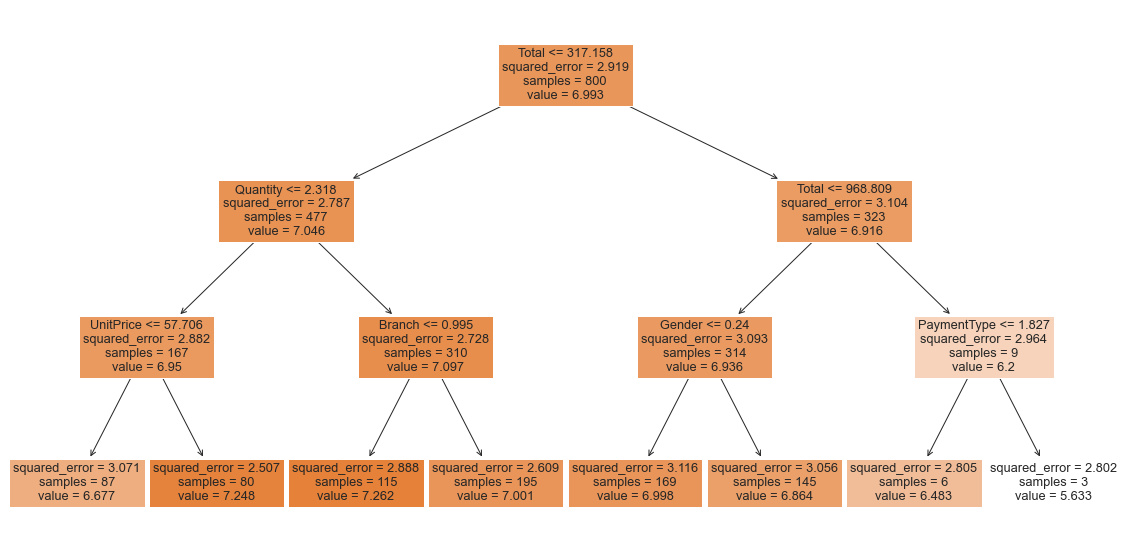

In [151]:
plt.figure(figsize=(20,10))
_ = plot_tree(dtr.best_estimator_,feature_names=list(Xr.columns),filled=True)

RMSE on test data

In [160]:
-dtr.score(Xr_test,yr_test)

1.7642860526189212